In [1]:
import os
import json
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor

# Displaying pd Dataframe options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
%%time
# Get datas from pickle
train_df = pd.read_pickle('train_df.pickle')
train_df['date'] = pd.to_datetime(train_df['date'], format='%Y%m%d')
train_df['weekday'] = train_df['date'].dt.weekday_name
train_df['day_off'] = (train_df['date'].dt.dayofweek > 4).astype(int)


CPU times: user 2.91 s, sys: 811 ms, total: 3.72 s
Wall time: 3.78 s


In [3]:
%%time
test_df = pd.read_pickle('test_df.pickle')
test_df['date'] = pd.to_datetime(test_df['date'], format='%Y%m%d')
test_df['weekday'] = test_df['date'].dt.weekday_name
test_df['day_off'] = (test_df['date'].dt.dayofweek > 4).astype(int)

CPU times: user 2.68 s, sys: 917 ms, total: 3.6 s
Wall time: 3.72 s


In [4]:
def check_diff_in_dfs():
    print('train_df \ test_df', set(train_df.columns).difference(set(test_df.columns)))
    print('test_df \ train_df', set(test_df.columns).difference(set(train_df.columns)))

In [5]:
# Data revision
check_diff_in_dfs()

train_df \ test_df {'transactionRevenue'}
test_df \ train_df set()


#### на пример adContent, где очень мало заполнено данных создать рядом новую фичу 'заполнена ли adContent'. Может быть сам adContent дропуть, поскольку она не несет информацию. Отступаем от обучения, работаем с данными.

In [108]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId', 'visitNumber', 'visitStartTime', 'operatingSystem', 'isMobile', 'deviceCategory', 'browser', 'subContinent', 'country', 'continent', 'region', 'networkDomain', 'city', 'metro', 'bounces', 'transactionRevenue', 'hits', 'pageviews', 'newVisits', 'medium', 'campaign', 'referralPath', 'isTrueDirect', 'keyword', 'adContent', 'source', 'slot', 'adNetworkType', 'gclId', 'page', 'targetingCriteria', 'isVideoAd', 'weekday', 'day_off'], dtype='object')

In [6]:
'channelGrouping'

'channelGrouping'

In [7]:
train_df['channelGrouping'].value_counts()

Organic Search    381561
Social            226117
Direct            143026
Referral          104838
Paid Search        25326
Affiliates         16403
Display             6262
(Other)              120
Name: channelGrouping, dtype: int64

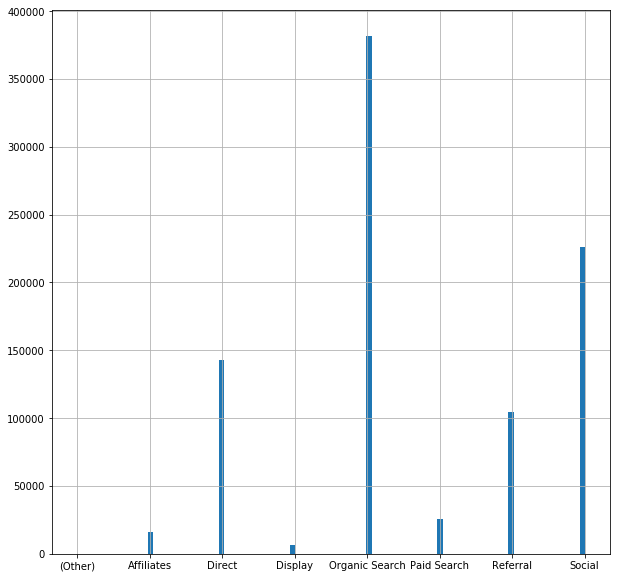

In [110]:
%matplotlib inline
train_df.channelGrouping.hist(bins=100, figsize=(10,10))

In [9]:
'date'

'date'

In [10]:
train_df['date'].value_counts()

2016-11-28    4807
2016-11-15    4685
2016-11-14    4466
2016-11-30    4435
2016-10-26    4375
2016-11-29    4337
2016-11-16    4334
2016-10-04    4322
2016-12-05    4265
2017-04-26    4224
2016-12-01    4200
2016-10-27    4162
2016-11-21    4143
2016-11-17    4074
2016-10-24    4063
2016-11-10    4055
2016-11-03    4014
2016-11-02    3960
2016-11-22    3942
2016-11-08    3899
2016-10-25    3842
2016-11-07    3832
2016-10-31    3827
2016-11-23    3805
2016-10-28    3791
2016-10-05    3770
2016-11-24    3770
2016-11-25    3759
2016-10-20    3755
2016-11-09    3752
              ... 
2016-08-13    1596
2017-04-30    1594
2016-10-01    1589
2016-12-26    1586
2017-01-15    1576
2017-04-29    1566
2017-06-11    1555
2017-02-04    1549
2017-04-23    1548
2017-06-10    1545
2017-06-04    1534
2017-01-14    1526
2017-02-05    1522
2017-06-24    1510
2017-04-16    1507
2017-04-15    1506
2017-05-27    1502
2017-05-28    1463
2017-06-18    1432
2017-05-07    1400
2017-06-03    1399
2017-06-17  

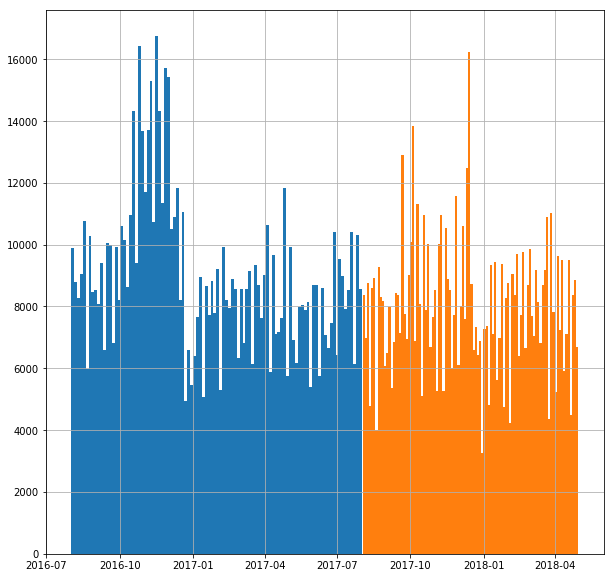

In [112]:
%matplotlib inline
train_df.date.hist(bins=100, figsize=(10,10))
test_df.date.hist(bins=100, figsize=(10,10))


In [12]:
'fullVisitorId' # ???

'fullVisitorId'

In [116]:
visits_counts = dict(train_df['fullVisitorId'].value_counts())
train_df['VisitsCount'] = train_df['fullVisitorId'].map(visits_counts)

In [122]:
print(sum((train_df['VisitsCount'] < 2) & (train_df['transactionRevenue'] != 0)))
print(sum((train_df['VisitsCount'] < 2) & (train_df['transactionRevenue'] == 0)))
print(sum((train_df['VisitsCount'] >= 2) & (train_df['transactionRevenue'] != 0)))
print(sum((train_df['VisitsCount'] >= 2) & (train_df['transactionRevenue'] == 0)))

3232
620790
8283
271348


In [125]:
full_df = pd.concat([train_df, test_df], axis=0)
test_df['transactionRevenue'] = np.nan

In [133]:
count_user_by_visits = {}
full_df = pd.concat([train_df, test_df], axis=0)

In [135]:
def check_count_by_visits(Id):
    if Id in count_user_by_visits:
        count_user_by_visits[Id]+= 1
    else:
        count_user_by_visits[Id]= 1
    
    return count_user_by_visits[Id]

In [138]:
full_df['visit_index'] = [check_count_by_visits(user) for user in full_df['fullVisitorId']]

In [139]:
full_df

,VisitsCount,adContent,adNetworkType,bounces,browser,campaign,channelGrouping,city,continent,country,date,day_off,deviceCategory,fullVisitorId,gclId,hits,isMobile,isTrueDirect,isVideoAd,keyword,medium,metro,networkDomain,newVisits,operatingSystem,page,pageviews,referralPath,region,sessionId,slot,source,subContinent,targetingCriteria,transactionRevenue,visitId,visitNumber,visitStartTime,weekday,visit_index
538675,1.0,no_key,no_key,1,Safari,(not set),Direct,not available in demo dataset,Americas,United States,2016-08-01,0,mobile,423043652415339154,no_key,1,True,True,no_key,no_key,(none),not available in demo dataset,(not set),no_key,iOS,no_key,1,no_key,not available in demo dataset,0423043652415339154_1470034812,no_key,(direct),Northern America,no_key,0.0,1470034812,3,1470034812,Monday,1
538232,1.0,no_key,no_key,1,Chrome,(not set),Social,not available in demo dataset,Asia,Thailand,2016-08-01,0,desktop,8294721032567046680,no_key,1,False,no_key,no_key,no_key,referral,not available in demo dataset,unknown.unknown,1,Windows,no_key,1,/yt/about/,not available in demo dataset,8294721032567046680_1470035066,no_key,youtube.com,Southeast Asia,no_key,0.0,1470035066,1,1470035066,Monday,1
539087,1.0,no_key,no_key,no_key,Amazon Silk,(not set),Organic Search,not available in demo dataset,Americas,United States,2016-08-01,0,tablet,7718623669497357235,no_key,5,True,no_key,no_key,(not provided),organic,not available in demo dataset,(not set),1,Android,no_key,5,no_key,not available in demo dataset,7718623669497357235_1470035081,no_key,google,Northern America,no_key,0.0,1470035081,1,1470035081,Monday,1
539300,1.0,no_key,no_key,no_key,Chrome,(not set),Organic Search,not available in demo dataset,Americas,Canada,2016-08-01,0,desktop,4798058133221713505,no_key,9,False,no_key,no_key,(not provided),organic,not available in demo dataset,bell.ca,1,Windows,no_key,7,no_key,not available in demo dataset,4798058133221713505_1470035161,no_key,google,Northern America,no_key,0.0,1470035161,1,1470035161,Monday,1
538453,1.0,no_key,no_key,1,Chrome,(not set),Direct,Quezon City,Asia,Philippines,2016-08-01,0,desktop,5076747981380011349,no_key,1,False,True,no_key,no_key,(none),(not set),pldt.net,1,Windows,no_key,1,no_key,Metro Manila,5076747981380011349_1470035170,no_key,(direct),Southeast Asia,no_key,0.0,1470035170,1,1470035170,Monday,1
538454,7.0,no_key,no_key,1,Safari,(not set),Direct,San Francisco,Americas,United States,2016-08-01,0,mobile,143953260196124648,no_key,1,True,True,no_key,no_key,(none),San Francisco-Oakland-San Jose CA,(not set),no_key,iOS,no_key,1,no_key,California,143953260196124648_1470035292,no_key,(direct),Northern America,no_key,0.0,1470035292,5,1470035292,Monday,1
538274,2.0,no_key,no_key,1,Safari,(not set),Direct,San Francisco,Americas,United States,2016-08-01,0,tablet,9234156111722725905,no_key,1,True,True,no_key,no_key,(none),San Francisco-Oakland-San Jose CA,(not set),no_key,iOS,no_key,1,no_key,California,9234156111722725905_1470035429,no_key,(direct),Northern America,no_key,0.0,1470035429,2,1470035429,Monday,1
539202,2.0,no_key,no_key,no_key,Chrome,(not set),Organic Search,Santa Clara,Americas,United States,2016-08-01,0,mobile,1757409464136963580,no_key,7,True,no_key,no_key,(not provided),organic,San Francisco-Oakland-San Jose CA,comcast.net,no_key,Android,no_key,5,no_key,California,1757409464136963580_1470035457,no_key,google,Northern America,no_key,0.0,1470035457,3,1470035457,Monday,1
538027,1.0,no_key,no_key,1,Chrome,(not set),Social,not available in demo dataset,Americas,United States,2016-08-01,0,desktop,3471645573420610711,no_key,1,False,no_key,no_key,no_key,referral,not available in demo dataset,verizon.net,1,Windows,no_key,1,/yt/about/,not available in demo dataset,3471645573420610711_1470035501,no_key,youtube.com,Northern America,no_key,0.0,1470035501,1,1470035501,Monday,1
537930,4.0,no_key,no_key,no_key,Safari,(not set),Direct,not available in demo dataset,Europe,United Kingdom,2016-08-01,0,mobile,4283942788674999975,no_key,53,True

(array([7518., 2219.,  768.,  371.,  101.,  152.,   84.,   55.,   45.,
          31.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <a list of 10 Patch objects>)

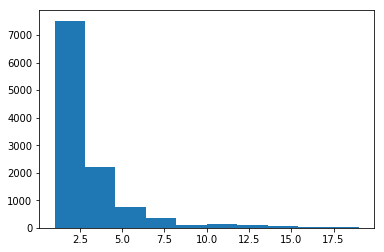

In [142]:
plt.hist(full_df[(full_df['transactionRevenue']>0) & (full_df['visit_index'] < 20)]['visit_index'])

In [13]:
train_df['fullVisitorId'].value_counts()

1957458976293878100    278
824839726118485274     205
3608475193341679870    201
1856749147915772585    199
3269834865385146569    155
7634897085866546110    148
4038076683036146727    138
3694234028523165868    129
720311197761340948     121
6254908847172458133    117
3525537916960843419    115
3148617623907142276    112
6018775317735347795    111
9801276214964695322    110
2194592743396253647    107
232377434237234751     105
7498695963354635199    104
9609104828919391966     99
3937673380007666721     94
949718915643445721      91
4913801338365738862     90
2082625651279391786     89
7813149961404844386     86
7445235885559107095     83
4578640586284138624     81
6588500311054802771     76
3041133261614133977     74
5208937953046059083     72
9292327473106748702     71
9534537897118577344     71
                      ... 
288758528135294381       1
4304352391539390587      1
5987950369393355730      1
6330888661601136276      1
7739964096955449177      1
2721379727257611896      1
4

In [14]:
%matplotlib inline
#????

In [15]:
'sessionId'

'sessionId'

In [16]:
train_df['sessionId'].value_counts()

949114864807798827_1488873279     2
6744852027946569144_1486367981    2
0368176022600320212_1477983528    2
4992819126088253676_1476945917    2
7337116917105358996_1486626864    2
4253966064261570867_1488527777    2
7549529166163705177_1473403649    2
5961536486573634219_1476080711    2
8290718395224810170_1470292507    2
8568578268232181901_1475131580    2
7253963382944474113_1491893936    2
9431459255925855651_1476427368    2
4968177382277050337_1480578835    2
7483600664917507409_1476512865    2
6344542374277652593_1495522728    2
1760800370259647003_1475823522    2
4853581114722495742_1476685840    2
8144221263768378141_1474958076    2
6238226081716604469_1479196770    2
4326430085858395868_1478591748    2
1468326551501903507_1480492763    2
2038050375681301021_1476514780    2
7211158502445215770_1499841487    2
1536917606431322139_1495349517    2
8198604450577095435_1480233504    2
36464293718895597_1483689578      2
6032038653782689840_1492498505    2
3976409111211002852_14819615

In [17]:
%matplotlib inline
#????

In [18]:
'visitId'

'visitId'

In [19]:
train_df['visitId'].value_counts()

1493146175    8
1478345904    6
1481369525    6
1484649802    6
1500856602    5
1495031359    5
1494374199    5
1473406997    4
1478942540    4
1490264449    4
1499778118    4
1489390306    4
1473406994    4
1490255839    4
1485823856    4
1490899032    4
1481365730    4
1478243627    4
1500856594    4
1500856591    4
1490274628    4
1475719086    4
1490384962    4
1484649800    4
1474613955    4
1489390296    4
1493406494    4
1479668456    4
1481874207    4
1500880897    4
             ..
1500254858    1
1482755722    1
1476466313    1
1474518720    1
1478710977    1
1472415427    1
1470258912    1
1474465530    1
1474490102    1
1476577011    1
1500606546    1
1491209962    1
1480728296    1
1474455271    1
1478651622    1
1470265061    1
1491347172    1
1495500507    1
1487107781    1
1490718365    1
1470361302    1
1476654805    1
1485035217    1
1478698703    1
1497432928    1
1478704844    1
1487085256    1
1500456028    1
1480814278    1
1497372675    1
Name: visitId, Length: 8

In [20]:
%matplotlib inline
#????

In [21]:
'visitNumber'

'visitNumber'

In [22]:
train_df['visitNumber'].value_counts()

1      703060
2       92548
3       35843
4       19157
5       11615
6        7677
7        5413
8        4031
9        3084
10       2415
11       1936
12       1573
13       1292
14       1092
15        928
16        809
17        699
18        611
19        541
20        497
21        446
22        399
23        355
24        340
25        304
26        272
27        245
28        223
29        203
30        188
        ...  
310         1
304         1
313         1
314         1
316         1
290         1
394         1
327         1
328         1
329         1
333         1
334         1
335         1
337         1
352         1
338         1
339         1
340         1
341         1
342         1
343         1
344         1
345         1
346         1
347         1
306         1
349         1
350         1
351         1
395         1
Name: visitNumber, Length: 384, dtype: int64

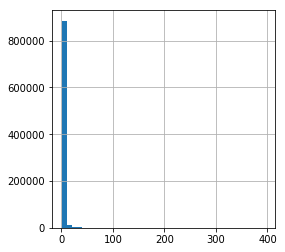

In [23]:
%matplotlib inline
train_df.visitNumber.hist(bins=40, figsize=(4,4))

In [24]:
'visitStartTime'

'visitStartTime'

In [25]:
train_df['visitStartTime'].value_counts()

1493146175    8
1481369525    6
1478345904    6
1484649802    6
1500856602    5
1495031359    5
1494374199    5
1475719086    4
1485823856    4
1499778118    4
1478243627    4
1477470782    4
1490384962    4
1500856594    4
1478942540    4
1489390296    4
1484649800    4
1498823774    4
1490264767    4
1500856591    4
1500856605    4
1479300875    4
1473406994    4
1481365730    4
1473406997    4
1488904421    4
1479668456    4
1481874207    4
1500880897    4
1490255839    4
             ..
1473763415    1
1482147925    1
1496825940    1
1500600455    1
1496391816    1
1475422345    1
1487937704    1
1498642627    1
1481859264    1
1485875385    1
1500567735    1
1496371382    1
1485891761    1
1475352751    1
1471156398    1
1481652395    1
1481650346    1
1481658534    1
1494290574    1
1477462181    1
1500528804    1
1485863075    1
1479567521    1
1490131103    1
1488027804    1
1475457178    1
1481756822    1
1496445074    1
1498540177    1
1497372675    1
Name: visitStartTime, Le

In [26]:
%matplotlib inline
#????

In [27]:
'operatingSystem'

'operatingSystem'

In [28]:
train_df['operatingSystem'].value_counts()

Windows          350072
Macintosh        253938
Android          123892
iOS              107665
Linux             35034
Chrome OS         26337
(not set)          4695
Windows Phone      1216
Samsung             280
BlackBerry          218
Nintendo Wii        100
Firefox OS           89
Xbox                 66
Nintendo WiiU        35
FreeBSD               9
OpenBSD               2
Nokia                 2
NTT DoCoMo            1
SunOS                 1
Nintendo 3DS          1
Name: operatingSystem, dtype: int64

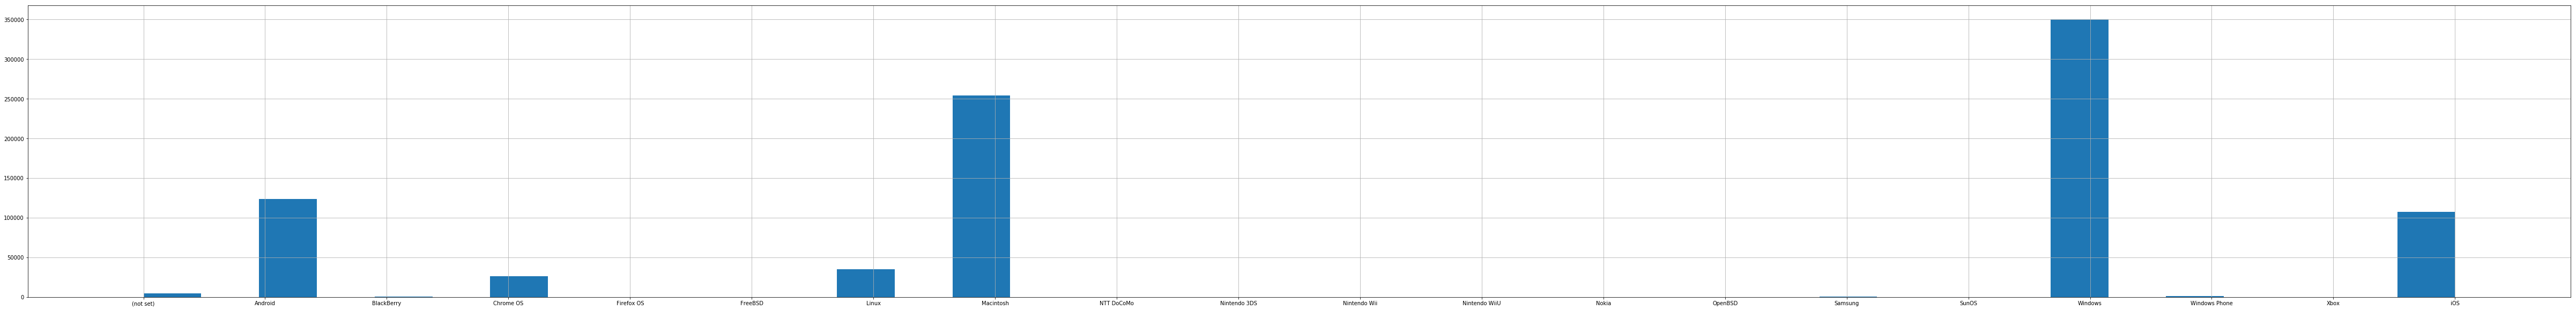

In [29]:
%matplotlib inline
train_df.operatingSystem.hist(bins=40, figsize=(85,10))

In [30]:
'isMobile'

'isMobile'

In [31]:
train_df['isMobile'].value_counts()

False    664530
True     239123
Name: isMobile, dtype: int64

In [32]:
%matplotlib inline
#????

In [33]:
'deviceCategory'

'deviceCategory'

In [34]:
train_df['deviceCategory'].value_counts()

desktop    664479
mobile     208725
tablet      30449
Name: deviceCategory, dtype: int64

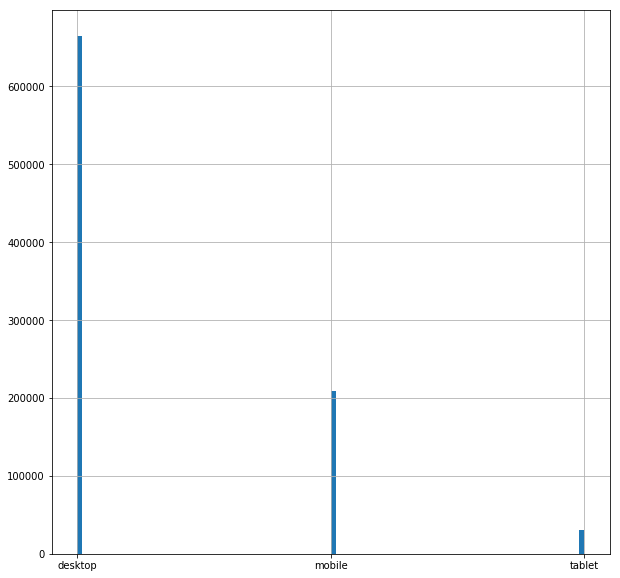

In [35]:
%matplotlib inline
train_df.deviceCategory.hist(bins=100, figsize=(10,10))

In [36]:
'browser'

'browser'

In [37]:
train_df['browser'].value_counts()

Chrome                                         620364
Safari                                         182245
Firefox                                         37069
Internet Explorer                               19375
Edge                                            10205
Android Webview                                  7865
Safari (in-app)                                  6850
Opera Mini                                       6139
Opera                                            5643
UC Browser                                       2427
YaBrowser                                        2096
Coc Coc                                           727
Amazon Silk                                       561
Android Browser                                   553
Mozilla Compatible Agent                          374
MRCHROME                                          263
Maxthon                                           246
BlackBerry                                        184
Nintendo Browser            

In [38]:
%matplotlib inline
#?

In [39]:
'subContinent'

'subContinent'

In [40]:
train_df['subContinent'].value_counts()

Northern America      390657
Southeast Asia         77800
Southern Asia          59321
Western Europe         59114
Northern Europe        58168
Eastern Asia           46919
Eastern Europe         45249
South America          41731
Western Asia           38443
Southern Europe        35780
Central America        15583
Australasia            14893
Northern Africa         7683
Western Africa          2573
Caribbean               2406
Southern Africa         2169
Eastern Africa          1927
(not set)               1468
Central Asia            1215
Middle Africa            393
Melanesia                 81
Micronesian Region        55
Polynesia                 25
Name: subContinent, dtype: int64

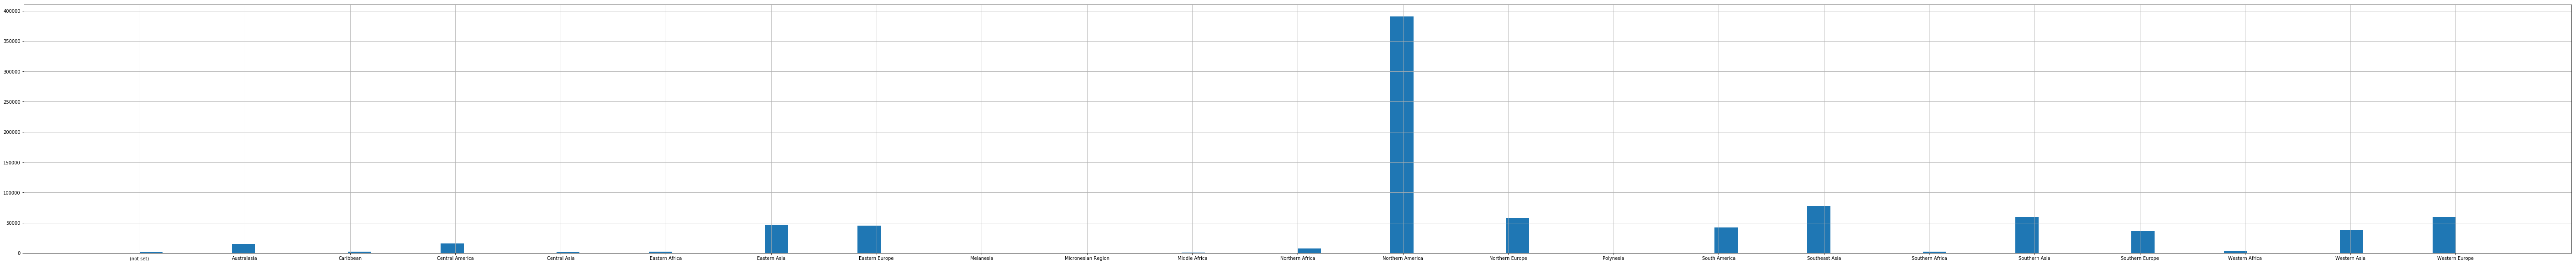

In [41]:
%matplotlib inline
train_df.subContinent.hist(bins=100, figsize=(100,10))

In [42]:
'country'

'country'

In [43]:
train_df['country'].value_counts()

United States               364744
India                        51140
United Kingdom               37393
Canada                       25869
Vietnam                      24598
Turkey                       20522
Thailand                     20123
Germany                      19980
Brazil                       19783
Japan                        19731
France                       15832
Mexico                       13225
Taiwan                       12996
Australia                    12698
Russia                       11662
Spain                        11658
Netherlands                  11453
Italy                        11332
Poland                        9693
Indonesia                     9273
Philippines                   9244
Singapore                     7172
Ireland                       6493
Malaysia                      6439
Romania                       6428
Ukraine                       5577
Israel                        5563
Peru                          5546
Sweden              

In [44]:
%matplotlib inline
#????

In [45]:
'continent'

'continent'

In [46]:
train_df['continent'].value_counts()

Americas     450377
Asia         223698
Europe       198311
Oceania       15054
Africa        14745
(not set)      1468
Name: continent, dtype: int64

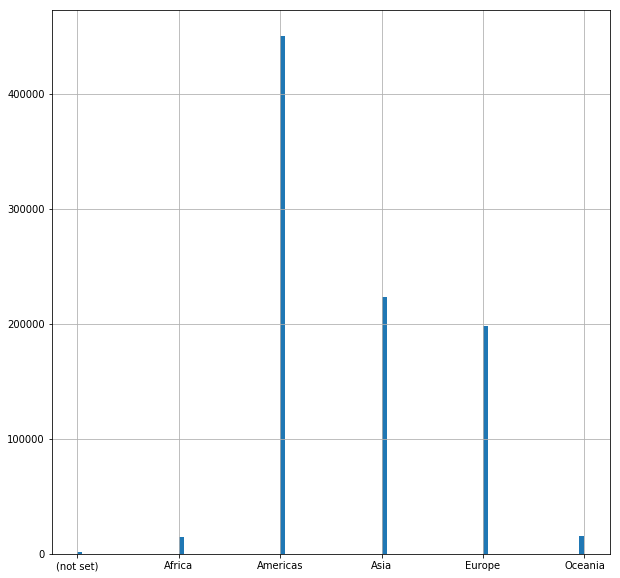

In [47]:
%matplotlib inline
train_df.continent.hist(bins=100, figsize=(10,10))

In [48]:
'region'

'region'

In [49]:
train_df['region'].value_counts()

not available in demo dataset    508229
California                       107495
(not set)                         27827
New York                          26433
England                           13198
Texas                              8749
Bangkok                            7709
Washington                         7642
Illinois                           7585
Ho Chi Minh                        7250
Istanbul                           6330
Maharashtra                        6184
Ontario                            5997
Taipei City                        5789
Karnataka                          5476
Delhi                              5278
Hanoi                              5141
New South Wales                    4932
Tamil Nadu                         4632
Ile-de-France                      4338
State of Sao Paulo                 4189
Telangana                          3955
County Dublin                      3650
Tel Aviv District                  3633
Tokyo                              3341


In [50]:
%matplotlib inline
#?

In [51]:
'networkDomain'

'networkDomain'

In [52]:
train_df['networkDomain'].value_counts()

(not set)                 244881
unknown.unknown           146034
comcast.net                28743
rr.com                     14827
verizon.net                13637
ttnet.com.tr               13228
comcastbusiness.net         9985
hinet.net                   7919
virginm.net                 6414
3bb.co.th                   6046
prod-infinitum.com.mx       5960
cox.net                     5812
sbcglobal.net               5388
btcentralplus.com           5304
att.net                     5230
google.com                  5035
optonline.net               4972
totbb.net                   4895
vnpt.vn                     4508
asianet.co.th               4374
pldt.net                    4008
rima-tde.net                3963
amazonaws.com               3769
t-ipconnect.de              3656
telecomitalia.it            3571
qwest.net                   3534
airtelbroadband.in          3389
virtua.com.br               3318
bell.ca                     2904
ztomy.com                   2845
          

In [53]:
'city'

'city'

In [54]:
train_df['city'].value_counts()

not available in demo dataset    508229
Mountain View                     40884
(not set)                         34262
New York                          26371
San Francisco                     20329
Sunnyvale                         13086
London                            12607
San Jose                          10295
Los Angeles                        8670
Bangkok                            7709
Chicago                            7444
Ho Chi Minh City                   7342
Istanbul                           6330
Bengaluru                          5468
Toronto                            5223
Hanoi                              5032
Seattle                            5025
Sydney                             4926
Dublin                             4877
Sao Paulo                          4106
Mumbai                             4099
Chennai                            4090
Paris                              4013
Hyderabad                          3934
Austin                             3790


In [55]:
'metro'

'metro'

In [56]:
train_df['metro'].value_counts()

not available in demo dataset                508229
(not set)                                    201766
San Francisco-Oakland-San Jose CA             95913
New York NY                                   26917
London                                        12571
Los Angeles CA                                 9995
Seattle-Tacoma WA                              7642
Chicago IL                                     7585
Austin TX                                      3790
Washington DC (Hagerstown MD)                  3380
Boston MA-Manchester NH                        2628
Houston TX                                     2475
Atlanta GA                                     2463
Detroit MI                                     2403
Roanoke-Lynchburg VA                           2227
Dallas-Ft. Worth TX                            2012
San Diego CA                                   1364
Portland OR                                    1319
Pittsburgh PA                                  1076
Denver CO   

In [57]:
'bounces'

'bounces'

In [58]:
train_df['bounces'].value_counts()

no_key    453023
1         450630
Name: bounces, dtype: int64

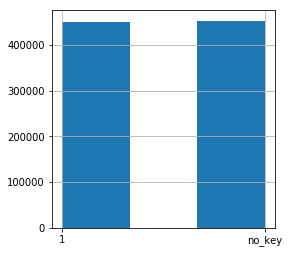

In [59]:
%matplotlib inline
train_df.bounces.hist(bins=3, figsize=(4,4))

In [60]:
'transactionRevenue'

'transactionRevenue'

In [61]:
train_df['transactionRevenue'].value_counts()

0.000000     892138
16.648135       256
16.759423       189
17.329739       187
17.617495       170
16.424845       135
17.840684       122
16.810743       116
16.587474        98
16.536148        93
16.769900        92
16.212496        84
17.909688        81
17.033986        77
18.197412        65
17.118360        64
17.117992        62
17.341283        54
17.504140        51
18.022886        46
14.503645        44
16.906098        40
17.175191        40
17.398474        39
17.229624        39
16.682841        38
17.229295        37
17.147001        37
16.379690        37
17.280934        37
              ...  
16.886350         1
19.134415         1
21.799500         1
19.408063         1
18.221986         1
17.337745         1
17.756510         1
20.937611         1
17.130060         1
19.109368         1
18.827611         1
18.270207         1
17.577408         1
16.922337         1
19.833130         1
16.959663         1
19.327729         1
19.941069         1
17.902831         1


In [62]:
'hits'

'hits'

In [63]:
train_df['hits'].value_counts()

1      446754
2      137952
3       70402
4       42444
5       30939
6       23918
7       19518
8       15484
9       12959
10      10640
11       9264
12       7879
13       6881
14       6194
15       5384
16       4716
17       4130
18       3755
19       3291
20       3064
21       2798
22       2477
23       2190
24       2126
25       1925
26       1718
27       1504
28       1406
29       1291
30       1289
        ...  
224         1
292         1
347         1
204         1
471         1
331         1
203         1
483         1
246         1
406         1
291         1
386         1
180         1
195         1
247         1
273         1
178         1
307         1
251         1
303         1
361         1
210         1
259         1
353         1
387         1
217         1
282         1
333         1
382         1
340         1
Name: hits, Length: 274, dtype: int64

In [64]:
'pageviews'

'pageviews'

In [65]:
train_df['pageviews'].value_counts()

1      452522
2      143770
3       73835
4       45192
5       33411
6       24688
7       19476
8       15272
9       12585
10      10104
11       8671
12       7097
13       6197
14       5291
15       4720
16       4010
17       3511
18       3150
19       2682
20       2409
21       2211
22       1949
23       1722
24       1567
25       1413
26       1318
27       1143
28       1091
29        875
30        873
        ...  
164         1
162         1
196         1
223         1
343         1
155         1
151         1
232         1
197         1
309         1
431         1
220         1
358         1
429         1
136         1
154         1
174         1
327         1
215         1
210         1
190         1
191         1
233         1
469         1
466         1
270         1
142         1
275         1
333         1
340         1
Name: pageviews, Length: 214, dtype: int64

In [66]:
'newVisits'

'newVisits'

In [67]:
train_df['newVisits'].value_counts()

1         703060
no_key    200593
Name: newVisits, dtype: int64

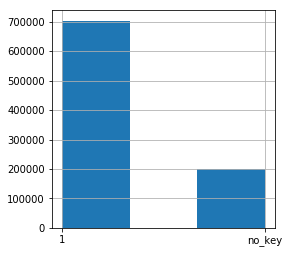

In [68]:
%matplotlib inline
train_df.newVisits.hist(bins=3, figsize=(4,4))

In [69]:
'medium'

'medium'

In [70]:
train_df['medium'].value_counts()

organic      381561
referral     330955
(none)       143026
cpc           25326
affiliate     16403
cpm            6262
(not set)       120
Name: medium, dtype: int64

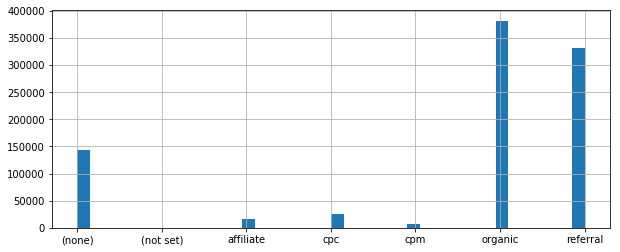

In [71]:
%matplotlib inline
train_df.medium.hist(bins=40, figsize=(10,4))

In [72]:
'campaign'

'campaign'

In [73]:
train_df['campaign'].value_counts()

(not set)                                          865347
Data Share Promo                                    16403
AW - Dynamic Search Ads Whole Site                  14244
AW - Accessories                                     7070
test-liyuhz                                           392
AW - Electronics                                       96
Retail (DO NOT EDIT owners nophakun and tianyu)        50
AW - Apparel                                           46
All Products                                            4
Data Share                                              1
Name: campaign, dtype: int64

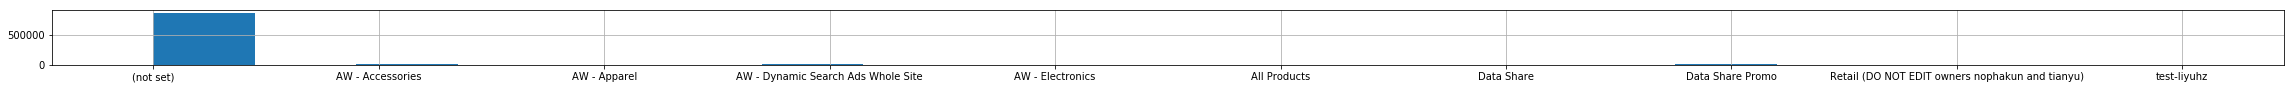

In [74]:
%matplotlib inline
train_df.campaign.hist(bins=20, figsize=(40,1))

In [75]:
'referralPath'

'referralPath'

In [76]:
train_df['referralPath'].value_counts()

no_key                                                                                                                                                                          572712
/                                                                                                                                                                                75523
/yt/about/                                                                                                                                                                       71036
/analytics/web/                                                                                                                                                                  14620
/yt/about/tr/                                                                                                                                                                    14599
/yt/about/vi/                                                                        

In [77]:
'isTrueDirect'

'isTrueDirect'

In [78]:
train_df['isTrueDirect'].value_counts()

no_key    629648
True      274005
Name: isTrueDirect, dtype: int64

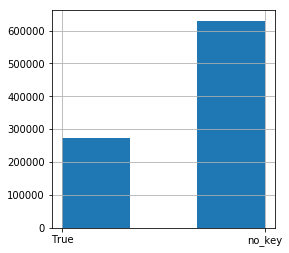

In [79]:
%matplotlib inline
train_df.isTrueDirect.hist(bins=3, figsize=(4,4))

In [80]:
'keyword'

'keyword'

In [81]:
train_df['keyword'].value_counts()

no_key                                       502929
(not provided)                               366363
6qEhsCssdK0z36ri                              11503
(Remarketing/Content targeting)                2298
1hZbAqLCbjwfgOH7                               2264
google merchandise store                       2209
Google Merchandise                             1648
google store                                   1277
youtube                                         568
(User vertical targeting)                       489
1X4Me6ZKNV0zg-jV                                467
(automatic matching)                            427
+google +store                                  377
+Google +Merchandise                            352
(content targeting)                             299
+google +merchandise +store                     258
YouTube Merchandise                             254
youtube merch                                   247
google merchandise                              238
google merch

In [82]:
'adContent'

'adContent'

In [83]:
train_df['adContent'].value_counts()

no_key                                         892707
Google Merchandise Collection                    5122
Google Online Store                              1245
Display Ad created 3/11/14                        967
Full auto ad IMAGE ONLY                           822
Ad from 12/13/16                                  610
Ad from 11/3/16                                   489
Display Ad created 3/11/15                        392
{KeyWord:Google Brand Items}                      251
{KeyWord:Google Merchandise}                      155
Ad from 11/7/16                                   123
Google Merchandise                                 87
First Full Auto Template Test Ad                   87
20% discount                                       75
{KeyWord:Google Branded Gear}                      67
{KeyWord:Looking for Google Bags?}                 65
Swag with Google Logos                             64
Display Ad created 11/17/14                        50
{KeyWord:Want Google Sticker

In [84]:
'source'

'source'

In [85]:
train_df['source'].value_counts()

google                                               400788
youtube.com                                          212602
(direct)                                             143028
mall.googleplex.com                                   66416
Partners                                              16411
analytics.google.com                                  16172
dfa                                                    5686
google.com                                             4669
m.facebook.com                                         3365
baidu                                                  3356
sites.google.com                                       2983
facebook.com                                           2296
siliconvalley.about.com                                2097
reddit.com                                             2022
qiita.com                                              1813
quora.com                                              1546
bing                                    

In [86]:
'slot'

'slot'

In [87]:
train_df['slot'].value_counts()

no_key    882193
Top        20956
RHS          504
Name: slot, dtype: int64

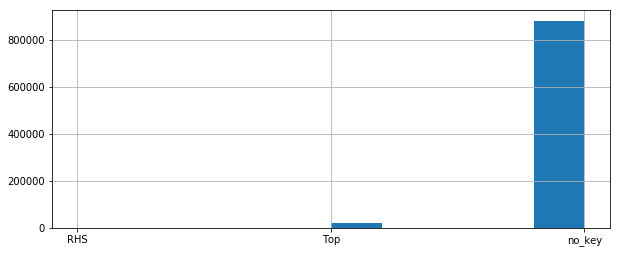

In [88]:
%matplotlib inline
train_df.slot.hist(bins=10, figsize=(10,4))

In [89]:
'adNetworkType'

'adNetworkType'

In [90]:
train_df['adNetworkType'].value_counts()

no_key             882193
Google Search       21453
Search partners         7
Name: adNetworkType, dtype: int64

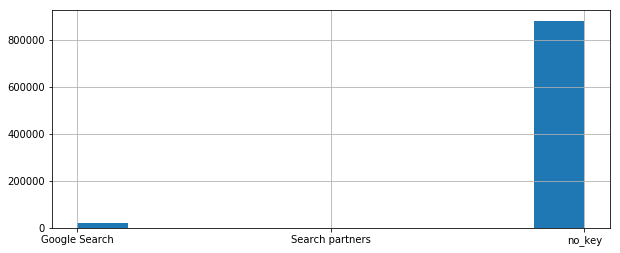

In [91]:
%matplotlib inline
train_df.adNetworkType.hist(bins=10, figsize=(10,4))

In [92]:
'gclId'

'gclId'

In [145]:
train_df[train_df['transactionRevenue']>0]['gclId'].value_counts()

no_key                                                                                          11059
CjwKEAiAj7TCBRCp2Z22ue-zrj4SJACG7SBExAsUjtkXuYAawLBg74jzCi7nH6wWoAshJH2ZmSvBABoCiALw_wcB            3
Cj0KEQjw-73GBRCC7KODl9zToJMBEiQAj1Jgf4L-TvGf-14G-liUxzP7_Q4OI1bRc9np2-EnmI0-InsaAq108P8HAQ          3
CjwKCAjwuOHHBRBmEiwAlEMW0B4j09Ol1dHOsKhSIJYpaA6fO2uZCAwUd6PriyuM10PHNpP90JfRrRoCcxwQAvD_BwE         3
Cj0KEQjw4fy_BRCX7b6rq_WZgI0BEiQAl78ndxq9PGCMhcb72UXFt_ZDi6330mAni4I_mqPZiQK_urIaAh6D8P8HAQ          2
Cj0KEQjwyJi_BRDLusby7_S7z-IBEiQAwCVvn3sj5cAWZcs1LF7NgsIauUQiwnL4CKF1boMcu0W8YrEaAhdj8P8HAQ          2
CjwKEAiAqJjDBRCG5KK6hq_juDwSJABRm03hn2fl7S-eRJYB48F0hYGU1g6DcZ4FZMH3Gl_rHkrdtBoCMKTw_wcB            2
CjwKEAjwse7JBRCJ576SqoD7lCkSJABF-bKu8D8PN52p1AIcZjQ4I8I_saTnfpL5ilhIk8uNP50X_xoCle7w_wcB            2
CI2Tw4qu0tQCFQOMaQodjx8P2g                                                                          2
CP3V2f3ty9ACFc1XDQoduy8AAQ                                                        

In [94]:
'page'

'page'

In [95]:
train_df['page'].value_counts()

no_key    882193
1          21362
2             73
3             10
5              7
7              3
4              2
9              2
14             1
Name: page, dtype: int64

In [96]:
'targetingCriteria'

'targetingCriteria'

In [97]:
train_df['targetingCriteria'].value_counts()

no_key        902193
empty_dict      1460
Name: targetingCriteria, dtype: int64

In [98]:
#!!!!

In [99]:
'isVideoAd'

'isVideoAd'

In [100]:
train_df['isVideoAd'].value_counts()

no_key    882193
False      21460
Name: isVideoAd, dtype: int64

In [101]:
#!!!!

In [102]:
'weekday'

'weekday'

In [103]:
train_df['weekday'].value_counts()

Tuesday      147279
Wednesday    146733
Thursday     142399
Monday       140905
Friday       128331
Sunday       100360
Saturday      97646
Name: weekday, dtype: int64

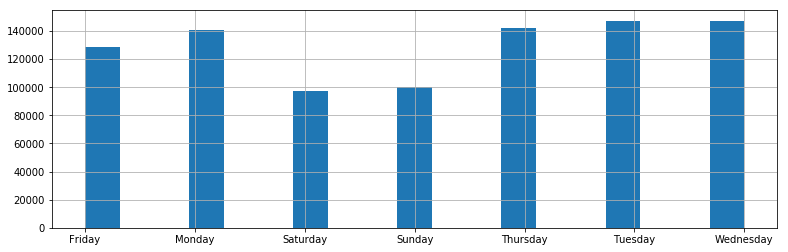

In [104]:
%matplotlib inline
train_df.weekday.hist(bins=19, figsize=(13,4))

In [105]:
'day_off'

'day_off'

In [106]:
train_df['day_off'].value_counts()

0    705647
1    198006
Name: day_off, dtype: int64

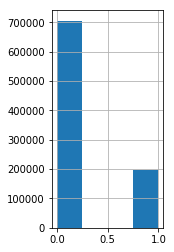

In [107]:
%matplotlib inline
train_df.day_off.hist(bins=4, figsize=(2,4))